In [1]:
import pandas as pd
import numpy as np
from os import cpu_count
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, StackingClassifier

In [2]:
from src.utils import load_data

data = load_data()

In [3]:
tree_allocation = np.round(cpu_count() / 2).astype(int)
cv_allocation = cpu_count() - tree_allocation
print(f'{tree_allocation} cores to model, {cv_allocation} to validation')

10 cores to model, 10 to validation


In [21]:
from src.utils import initialize_model_pipeline

log_reg = LogisticRegression(max_iter=10000, random_state=123)
tree_reg = RandomForestClassifier(min_samples_leaf=30, n_jobs=tree_allocation, random_state=123)

boosted_model = StackingClassifier(
    estimators=[
        ('rf', log_reg)
    ],
    final_estimator=tree_reg
)

pipeline = initialize_model_pipeline(boosted_model)
pipeline

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['hour_of_day', 'month']),
                                                 ('gen', Generator(),
                                                  ['hour_of_day']),
                                                 ('bin', 'passthrough',
                                                  ['weekday', 'summertime']),
                                                 ('weather',
                                                  WeatherTransformer(),
                                                  ['summertime', 'temp', 'dew',
                                                   'humidity', 'precip',
                                                   'snowdepth', 'windspeed',
                                                   'cloudcover',
                                                   'visibility'])])),
                ('model',
                 StackingClassifier(estimators=[('rf',
                                                 LogisticRegression(max_iter=10000,
                                                                    random_state=123))],
                                    final_estimator=RandomForestClassifier(min_samples_leaf=30,
                                                                           n_jobs=10,
                                                                           random_state=123)))])

In [5]:
from src.utils import cross_validate_model

accuracy_scores = cross_validate_model(pipeline,
                                       data,
                                       data['increase_stock'],
                                       n_splits=160,
                                       cpu_count=cv_allocation)

In [9]:
np.mean(accuracy_scores)

0.8850000000000001

In [22]:
from sklearn.metrics import f1_score, accuracy_score
results = []
for i in range(100):
    result = {}
    X_train, X_test, y_train, y_test = train_test_split(data, data['increase_stock'],
                                                      test_size=0.05, random_state=i)
    pipeline.fit(X_train,y_train)
    predict = pipeline.predict(X_test)
    f_score = f1_score(y_true=y_test, y_pred=predict)
    accuracy = accuracy_score(y_test, predict)
    
    result['f_score'] = f_score
    result['accuracy'] = accuracy
    result['predict'] = predict
    result['y'] = y_test
    results.append(result)


In [23]:
scores = pd.DataFrame(results)
scores

,f_score,accuracy,predict,y
0,0.500000,0.8000,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, ...",1073 0 326 1 1557 0 918 0 974 ...
1,0.777778,0.9500,"[1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, ...",75 1 1284 0 408 0 1282 0 1447 ...
2,0.687500,0.8750,"[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",407 1 1220 0 1200 1 308 0 1329 ...
3,0.666667,0.9125,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",147 0 938 0 492 0 1274 0 73 ...
4,0.720000,0.9125,"[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",289 0 1011 0 828 1 1478 1 57 ...
...,...,...,...,...
95,0.620690,0.8625,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",412 0 470 0 138 0 75 1 1113 ...
96,0.785714,0.9250,"[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1346 0 1425 1 242 1 519 0 1277 ...
97,0.545455,0.8750,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",235 0 942 0 867 0 873 0 459 ...
98,0.615385,0.8750,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",627 1 582 0 550 0 119 0 202 ...


In [24]:
scores.describe()

,f_score,accuracy
count,100.000000,100.000000
mean,0.631610,0.888125
std,0.130380,0.036340
min,0.285714,0.762500
25%,0.568571,0.871875
50%,0.666667,0.887500
75%,0.720000,0.912500
max,0.838710,0.950000


C:\Users\krasky\AppData\Local\Temp\ipykernel_9184\287132664.py:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(y=y_test, x=y_hat, palette='viridis')


<Axes: ylabel='increase_stock'>

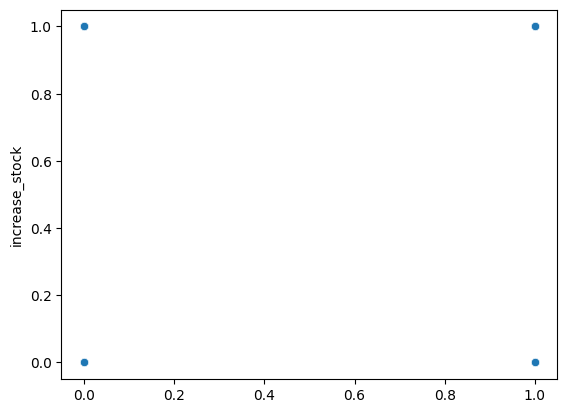

In [28]:
import seaborn as sns
X_train, X_test, y_train, y_test = train_test_split(data, data['increase_stock'],
                                                      test_size=0.2, random_state=123)
pipeline.fit(X_train, y_train)
y_hat = pipeline.predict(X_test)

sns.scatterplot(y=y_test, x=y_hat, palette='viridis')